### Case Study 3: Fuel Efficiency Versus Speed

**Objective:** Calculate the fuel efficiency in miles per gallon (MPG) or Liters per 100 km (L/100 km).

Machine Learning for Engineers: [Automotive Monitoring](https://www.apmonitor.com/pds/index.php/Main/AutomotiveMonitoring)
- Description: Machine learning project with automotive data. Data includes travel distance, time, fuel rate, air flow, oxygen ratio, and other parameters available from an OBD2 interface.
- [Course Overview](https://apmonitor.com/pds)
- [Course Schedule](https://apmonitor.com/pds/index.php/Main/CourseSchedule)

<img width=400px align=left src='https://apmonitor.com/pds/uploads/Main/automotive_monitoring.png'>

In [1]:
import seaborn as sns
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler as mms
from tqdm.keras import TqdmCallback
import keras

C:\Users\johnh\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Import Data and Display Column names

In [2]:
url = 'http://apmonitor.com/pds/uploads/Main/automotive.txt'
data = pd.read_csv(url)
data.rename(columns={'Calculated instant fuel consumption (MPG)':"MPG"},inplace=True)
data.columns

Index(['time', 'Average fuel consumption (MPG)',
       'Average fuel consumption (total) (MPG)',
       'Average fuel consumption 10 sec (MPG)', 'Average speed (mph)', 'MPG',
       'Calculated instant fuel rate (gal./h)', 'Distance travelled (miles)',
       'Distance travelled (total) (miles)', 'Engine RPM (rpm)',
       'Fuel economizer (based on fuel system status and throttle position) ()',
       'Fuel used (gallon)', 'Fuel used (total) (gallon)',
       'Fuel used price ($)', 'Fuel used price (total) ($)',
       'Instant engine power (based on fuel consumption) (hp)',
       'MAF air flow rate (g/sec)',
       'Oxygen sensor 1 Wide Range Current (mA) (mA)',
       'Oxygen sensor 1 Wide Range Equivalence ratio ()',
       'Throttle position (%)', 'Vehicle acceleration (g)',
       'Vehicle speed (mph)', 'Unnamed: 22'],
      dtype='object')

### Reformat Time

In [3]:
from datetime import datetime
dtobj = datetime.strptime(data['time'].iloc[0],'%I:%M:%S.%f')
dtobj2 = datetime.strptime(data['time'].iloc[-1],'%I:%M:%S.%f')
dataf = data.copy()
dataf['time'] = data['time'].apply(func=lambda x: datetime.strptime(x,'%I:%M:%S.%f'))
dataf['timetot'] = dataf['time'].apply(lambda x:(x-dtobj).microseconds/10**6+(x-dtobj).seconds)
dataf['timetot'].sample(5)

31118    5815.961
40653    7368.583
17558    2843.785
27947    5296.783
38586    7034.749
Name: timetot, dtype: float64

### Plot and Visualize the Data

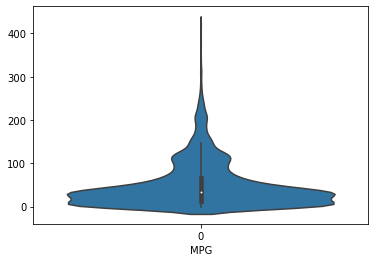

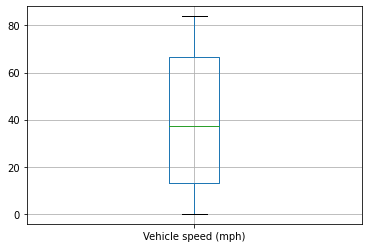

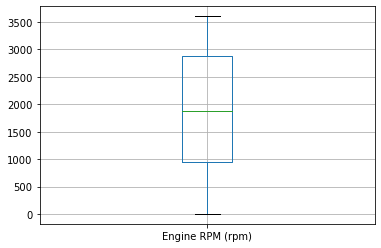

In [4]:
label = 'MPG'
#predict MPG from RPM, and speed
sns.violinplot(data=dataf[label])
plt.xlabel(label)
plt.show()
dataf.boxplot('Vehicle speed (mph)')
plt.show()
dataf.boxplot('Engine RPM (rpm)')
plt.show()

## Reformat Data
Use Vehicle Speed, Acceleration, and RPM as features. Visualize the effects of well-known aspects of driving on fuel efficiency.

In [5]:
rpm = 'Engine RPM (rpm)'
speed = 'Vehicle speed (mph)'
speeds = dataf[speed].dropna()
acel = 'Vehicle acceleration (g)'
gal = 'Fuel used (gallon)'
alls = [acel,speed,rpm,label]
dataf[alls].isna().sum()
datan = dataf[alls].copy().fillna(method='ffill').drop_duplicates()
datan = datan[datan[label]>0]
datan = datan[datan[label]<45] #Anything higher than this is most likely coasting
datan.sample(20)

,Vehicle acceleration (g),Vehicle speed (mph),Engine RPM (rpm),MPG
30716,-0.009005,43.495983,1876.0,16.923662
26071,0.016617,55.923407,2394.0,31.767946
37556,0.009170,3.728227,804.0,18.299301
2352,0.083594,19.262507,1535.0,9.500661
23761,-0.008740,80.778255,3474.0,44.537146
10597,-0.008531,70.836316,3048.0,44.673748
21791,0.017660,70.214945,3000.0,24.916879
40769,0.085165,27.340332,1793.0,14.476563
37564,0.009181,4.349598,817.0,11.346985
42997,-0.036043,50.331067,2183.0,18.871059


### Show Heatmap

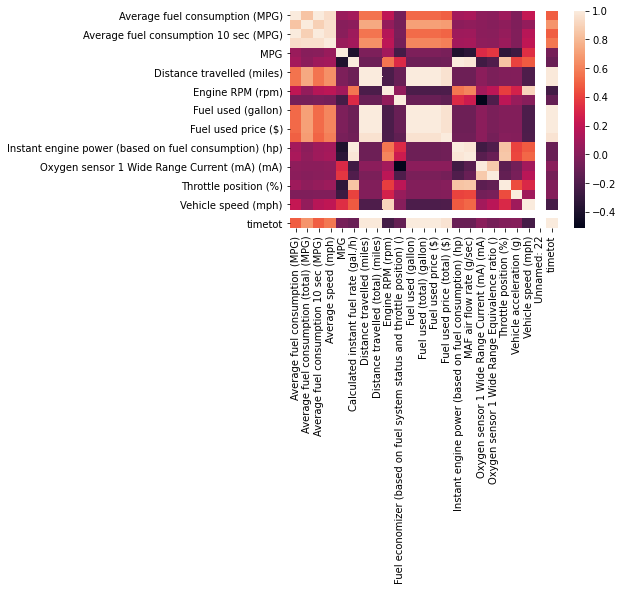

In [6]:
sns.heatmap(dataf.copy().fillna(method='ffill').drop_duplicates().corr(),annot=False,fmt='f')
plt.show()

### Create Pairplot

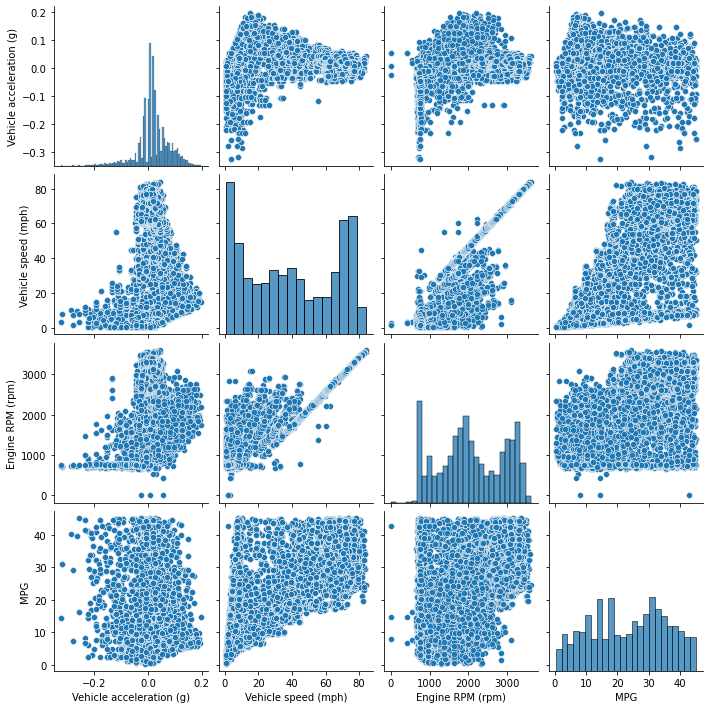

In [7]:
sns.pairplot(datan)
plt.show()

### Scale Data, Train model, and show accuracy

0.1501 2.978, r2=0.8816379734819699


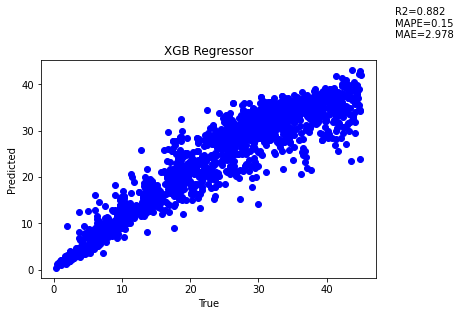

In [8]:
s = mms()

use = alls.copy()
use.remove('MPG')

dataS = pd.DataFrame(np.sqrt(np.array(s.fit_transform(datan))), columns =alls)
Xtrain, Xtest, ytrain, ytest = tts(dataS[use], dataS[label], test_size = .2, random_state = 87)

model = xgb.XGBRegressor()

m = model.fit(dataS[use], dataS[label])

datatest = Xtest.join(ytest,how='right')
yp = m.predict(datatest[use])
unscaled = pd.DataFrame(s.inverse_transform((datatest.values)**2),columns = alls)
datap = datatest.copy()
datap[label] = yp
unscaledy = unscaled[label]
unscaledp = pd.DataFrame(s.inverse_transform(datap.values**2),columns=alls)[label]
perc = MAPE(unscaledy, unscaledp)

scoree = MAE(unscaledy, unscaledp)
scorer = r2(unscaledy, unscaledp)
plt.plot(unscaledy, unscaledp, 'bo')
plt.text(50,50,f'R2={round(scorer,3)}\nMAPE={round(perc,3)}\nMAE={round(scoree,3)}')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('XGB Regressor')
print(f'{perc:.4g}',f'{scoree:.4g}, r2={scorer}')
# linear model
reg = LinearRegression().fit(dataS[use], dataS[label])
ypr = reg.predict(datatest[use])
r2lin = r2(datatest[label],ypr)

### Create a Neural Network to compare performance with XGBoost Regression

In [9]:
mod = Sequential()
mod.add(Dense(3,input_shape=(Xtrain.shape[1],),activation='relu'))
mod.add(Dense(1,activation='linear'))
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [10]:
mod.compile(optimizer='sgd', loss='mse')
history = mod.fit(Xtrain,ytrain,epochs = 350, verbose=True, \
                  validation_data=(Xtest,ytest),\
                  callbacks=[TqdmCallback(verbose=1), \
                             EarlyStopping(monitor = 'loss',patience=4)])

Epoch 1/350
227/227 [==============================] - 2s 8ms/step - loss: 0.0874 - val_loss: 0.0405
Epoch 2/350
227/227 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0323
Epoch 3/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0285
Epoch 4/350
227/227 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0266
Epoch 5/350
227/227 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0255
Epoch 6/350
227/227 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0248
Epoch 7/350
227/227 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0244
Epoch 8/350
227/227 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0240
Epoch 9/350
227/227 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0236
Epoch 10/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0246 - val_lo

227/227 [==============================] - 0s 1ms/step - loss: 0.0168 - val_loss: 0.0162
Epoch 82/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0172 - val_loss: 0.0161
Epoch 83/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 84/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 85/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0170 - val_loss: 0.0161
Epoch 86/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 87/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0165 - val_loss: 0.0160
Epoch 88/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 89/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 90/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0162 - val_loss: 

### Plot Learning History

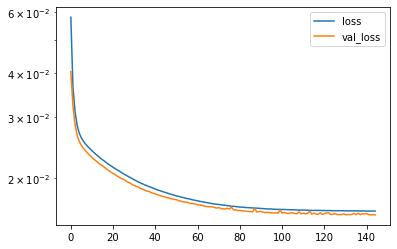

In [11]:
plt.semilogy(history.history['loss'],label='loss')
plt.semilogy(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
mod.save('Model_3var.h5')

0.1871 4.412, r2=0.6485690700252325


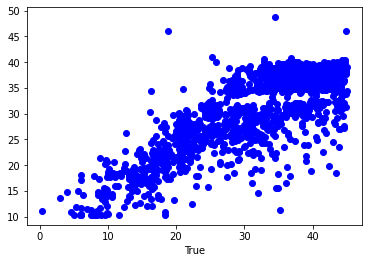

In [12]:
mod = keras.models.load_model('Model_3var.h5')
yp = mod.predict(datatest[use])
unscaled = pd.DataFrame(s.inverse_transform(datatest),columns = alls)
datap = datatest.copy()
datap[label] = yp
unscaledy = unscaled[label]
unscaledp = pd.DataFrame(s.inverse_transform(datap),columns=alls)[label]
perc = MAPE(unscaledy, unscaledp)

scoree = MAE(unscaledy, unscaledp)
scorer = r2(unscaledy, unscaledp)
plt.plot(unscaledy, unscaledp, 'bo')
plt.xlabel('True')
print(f'{perc:.4g}',f'{scoree:.4g}, r2={scorer}')

### View Predictions

RPM,Speed,Acceleration median values
0.744363176884441 0.6747028090922809 0.8112128339807486


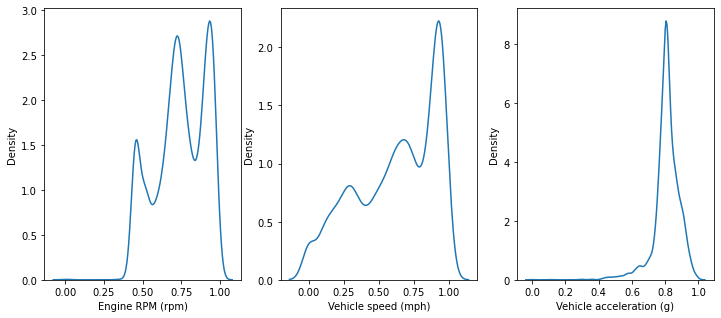

In [16]:
# XGB Regression
rpmmed = np.ones(datan.shape[0])*dataS[rpm].median()
speedmed = np.ones(datan.shape[0])*dataS[speed].median()
acelmed = np.ones(datan.shape[0])*dataS[acel].median()
print('RPM,Speed,Acceleration median values')
print(dataS[rpm].median(),dataS[speed].median(),dataS[acel].median())
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
sns.kdeplot(dataS[rpm])
plt.subplot(1,3,2)
sns.kdeplot(dataS[speed])
plt.subplot(1,3,3)
sns.kdeplot(dataS[acel])
plt.show()

## Display Extrapolations with one variable

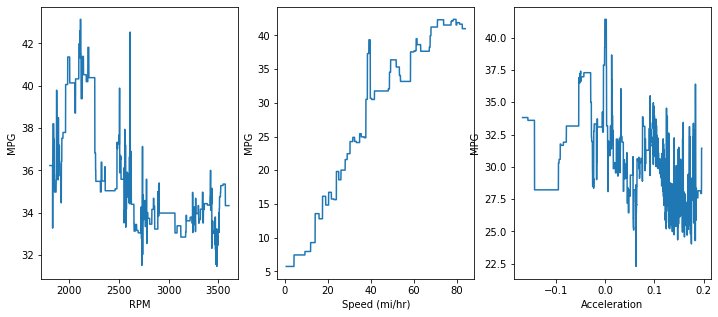

In [21]:
# Use the XGBoost model since it performed better
n = datan.shape[0]
rpmvar = np.linspace(.5,1,n)
speedvar = np.linspace(0,1,n)
acelvar = np.linspace(.3,1,n)
rpmdf = pd.DataFrame(np.array([acelmed,speedmed,rpmvar]).T,columns=use)
speeddf = pd.DataFrame(np.array([acelmed,speedvar,rpmmed]).T,columns=use)
aceldf = pd.DataFrame(np.array([acelvar,speedmed,rpmmed]).T,columns=use)
rpmpred = m.predict(rpmdf)
speedpred = m.predict(speeddf)
acelpred = m.predict(aceldf)
trrpm = pd.DataFrame(s.inverse_transform(rpmdf.join(pd.DataFrame(rpmpred))),columns = use+[label])
trspeed = pd.DataFrame(s.inverse_transform(speeddf.join(pd.DataFrame(speedpred))),columns = use+[label])
tracel = pd.DataFrame(s.inverse_transform(aceldf.join(pd.DataFrame(acelpred))),columns = use+[label])

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(trrpm[rpm],trrpm[label])
plt.ylabel('MPG'); plt.xlabel('RPM')
plt.subplot(1,3,2)
plt.plot(trspeed[speed],trspeed[label])
plt.ylabel('MPG'); plt.xlabel('Speed (mi/hr)')
plt.subplot(1,3,3)
plt.plot(tracel[acel],tracel[label])
#tracel.plot(x=acel,y=label)
plt.ylabel('MPG'); plt.xlabel('Acceleration')
plt.show()

### Discussion

The three cross sections show the MPG varying a single variable while the other variables are held constant at a median value. This method inherently misses important behavior because the other values are restricted to the median. However, the trends are visible and most likely carry throughout portions of the 4-d model, even if the actual magnitudes vary. Some observations:

- The highest MPG (fuel efficiency) is at lower RPM for the engine. The data where the car is coasting may influence this higher trend at lower RPM.
- The highest MPG is at the highest speed with highway driving. City driving fuel efficiency is lower due to braking action and lower average velocity.
- Fuel efficiency decreases with higher acceleration.

### 4D Figure with 3D + Color

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
datass = dataS.copy()
datass[label] = m.predict(dataS[use])
datainv = pd.DataFrame(s.inverse_transform(datass),columns = use+[label])
img = ax.scatter(datainv[rpm],datainv[speed],datainv[acel],c=datainv[label],cmap = plt.hot())
fig.colorbar(img)
plt.xlabel('RPM')
plt.ylabel('Speed')
ax.set_zlabel('Acceleration')
ax.view_init(azim=34,elev = -51)
plt.show()